In [1]:
import pyart
import numpy as np
import pandas as pd
import xarray as xr
import nexrad_utils as nexu
import glob
import os
import matplotlib.pyplot as plt

import s3fs
import tempfile

%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



### User defined variables
Start and end time, radar name


In [2]:
ss = '01-08-2017 00Z'
ee = '01-10-2017 00Z'
icao = 'KRGX'
target_azimuth = 235

/Users/guy/anaconda/envs/py3/lib/python3.5/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-11-30 19:59:00.402796. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


#### Get the file list for processing

In [3]:
file_list = nexu.get_s3_list(ss, ee, icao)
#file_list = glob.glob('/Users/guy/software/tmp/nexhov/data/KRGX*')

/Users/guy/anaconda/envs/py3/lib/python3.5/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-11-30 19:59:05.186968. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


#### Copy files locally from S3 - For testing purposes

s3conn = s3fs.S3FileSystem(anon=True)
for filen in file_list:
    path, filename = os.path.split(filen)
    with s3conn.open(filen, 'rb') as temp88d:
        f = open(os.path.join('/Users/guy/software/tmp/nexhov/', filename), 'wb')
        f.write(temp88d.read())
        print("{} Copied locally".format(filename))
        f.close()

#### Pull data from AWS S3 and composite along the target azimuth

In [4]:
#hov = nexu.get_composite_from_list(file_list, 'KRGX', 'reflectivity', target_azimuth)
hovd = nexu.get_composite_from_s3_list(file_list, 'KRGX', 'reflectivity', target_azimuth)

/Users/guy/anaconda/envs/py3/lib/python3.5/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-11-30 19:59:15.149975. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
/Users/guy/anaconda/envs/py3/lib/python3.5/site-packages/pyart/core/transforms.py:205: RuntimeWarning: invalid value encountered in arccos
  full_angle_rad = np.arccos(dot_product)
/Users/guy/anaconda/envs/py3/lib/python3.5/site-packages/pyart/core/transforms.py:185: RuntimeWarning: invalid value encountered in less
  edges[edges < 0] += 360     # range from [-180, 180] to [0, 360]


#### Create an xarray Dataset for easier plotting

In [23]:
hovd = xr.Dataset()
hovd['time'] = times
hovd['range'] =  ranges
hovd['ref'] = ('time', 'range'), np.vstack(rays)
hovd.ref.values[hovd.ref.values > 1000] = np.nan

/Users/guy/anaconda/envs/py3/lib/python3.5/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-11-30 09:41:39.212271. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [5]:
hovd

/Users/guy/anaconda/envs/py3/lib/python3.5/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-12-01 07:30:06.821063. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


<xarray.Dataset>
Dimensions:  (range: 1832, time: 806)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-08T00:00:35 2017-01-08T00:03:47 ...
  * range    (range) float32 2125.0 2375.0 2625.0 2875.0 3125.0 3375.0 ...
Data variables:
    ref      (time, range) float32 -14.0 -20.0 -14.0 -14.5 -13.5 -15.5 -13.0 ...

/Users/guy/anaconda/envs/py3/lib/python3.5/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-12-01 08:39:10.712293. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


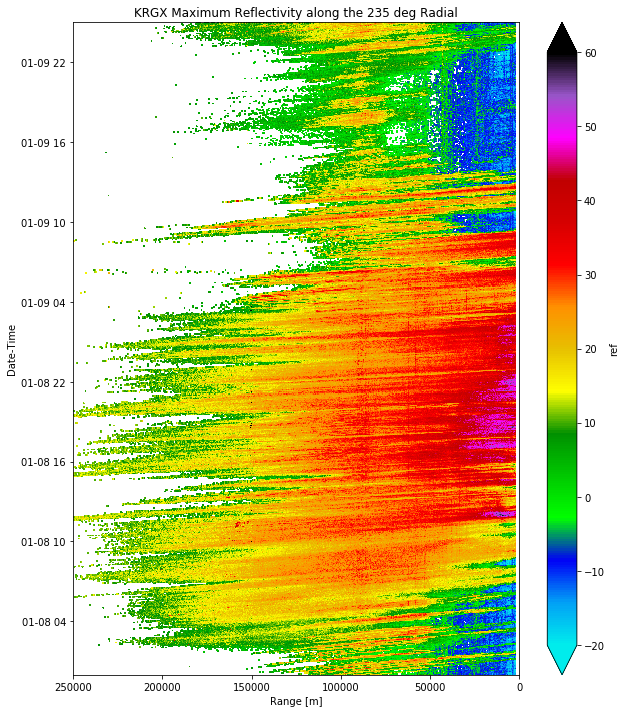

In [14]:
fig, ax = plt.subplots(figsize=(10, 12))
hovd.ref.plot.pcolormesh(ax=ax, cmap=pyart.graph.cm.NWSRef, vmin=-20., vmax=60.)
ax.set_xlim(250000, 0.)
ax.set_xlabel('Range [m]')
ax.set_ylabel('Date-Time')
ax.set_title('KRGX Maximum Reflectivity along the 235 deg Radial')

#### Save data to output file

In [13]:
hovd.to_netcdf(path='20170108_10_235_radial_comp.nc')

/Users/guy/anaconda/envs/py3/lib/python3.5/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-12-01 07:38:43.709716. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
